# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [2]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [3]:
import os
import rasterio
import copy
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.1333, 0.1499, 0.1723,  ..., 0.0498, 0.0495, 0.0503],
         [0.1493, 0.1659, 0.1956,  ..., 0.0495, 0.0480, 0.0495],
         [0.1604, 0.1703, 0.1877,  ..., 0.0492, 0.0486, 0.0506],
         ...,
         [0.0375, 0.0364, 0.0373,  ..., 0.1566, 0.1612, 0.1607],
         [0.0416, 0.0370, 0.0370,  ..., 0.1624, 0.1639, 0.1682],
         [0.0530, 0.0445, 0.0390,  ..., 0.1513, 0.1711, 0.1735]],

        [[0.1650, 0.1854, 0.2122,  ..., 0.1146, 0.1158, 0.1175],
         [0.1840, 0.2002, 0.2486,  ..., 0.1155, 0.1152, 0.1169],
         [0.1940, 0.2016, 0.2363,  ..., 0.1149, 0.1152, 0.1172],
         ...,
         [0.0410, 0.0395, 0.0398,  ..., 0.2568, 0.2645, 0.2526],
         [0.0486, 0.0410, 0.0410,  ..., 0.2503, 0.2625, 0.2639],
         [0.0637, 0.0515, 0.0452,  ..., 0.2207, 0.2486, 0.2580]],

        [[0.1858, 0.2503, 0.3185,  ..., 0.0489, 0.0513, 0.0524],
         [0.2167, 0.2978, 0.3723,  ..., 0.0494, 0.0475, 0.0505],
         [0.2490, 0.2956, 0.3389,  ..., 0.0511, 0.0472, 0.

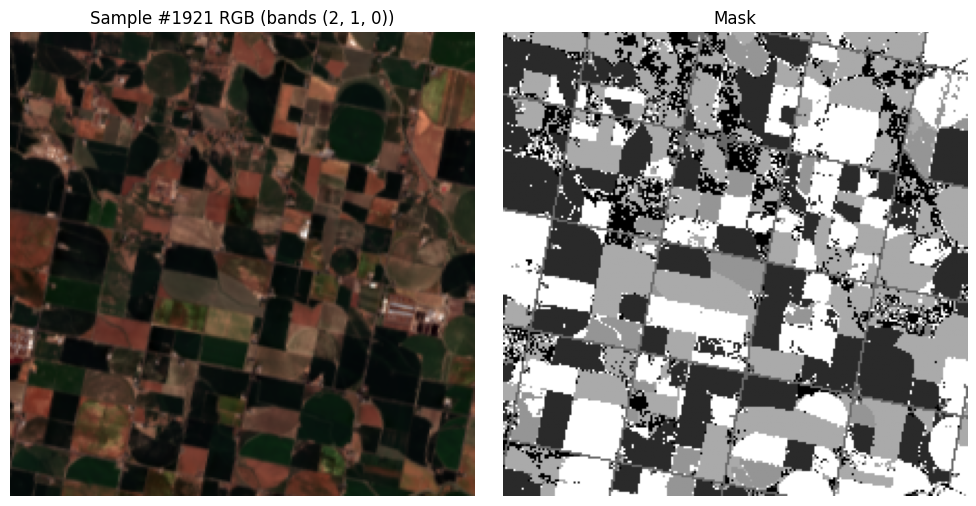

tensor([[[0.0912, 0.0723, 0.0897,  ..., 0.1521, 0.1274, 0.1422],
         [0.0981, 0.1070, 0.1179,  ..., 0.1259, 0.1174, 0.1234],
         [0.2398, 0.2284, 0.2304,  ..., 0.1105, 0.1085, 0.1169],
         ...,
         [0.2007, 0.1516, 0.1769,  ..., 0.0778, 0.0828, 0.0694],
         [0.1833, 0.1189, 0.1596,  ..., 0.0847, 0.0788, 0.0748],
         [0.2389, 0.1581, 0.1551,  ..., 0.0857, 0.0758, 0.0803]],

        [[0.1582, 0.1404, 0.1600,  ..., 0.1815, 0.1500, 0.1811],
         [0.1669, 0.1724, 0.1920,  ..., 0.1454, 0.1363, 0.1536],
         [0.2926, 0.2821, 0.2881,  ..., 0.1216, 0.1381, 0.1541],
         ...,
         [0.2739, 0.2176, 0.2263,  ..., 0.1006, 0.0988, 0.0713],
         [0.2469, 0.1852, 0.2213,  ..., 0.1033, 0.0992, 0.0965],
         [0.2853, 0.2071, 0.2071,  ..., 0.1029, 0.1001, 0.1102]],

        [[0.1256, 0.1151, 0.1665,  ..., 0.2230, 0.1851, 0.2083],
         [0.1623, 0.1804, 0.1935,  ..., 0.1636, 0.1488, 0.1653],
         [0.3664, 0.3524, 0.3499,  ..., 0.1345, 0.1408, 0.

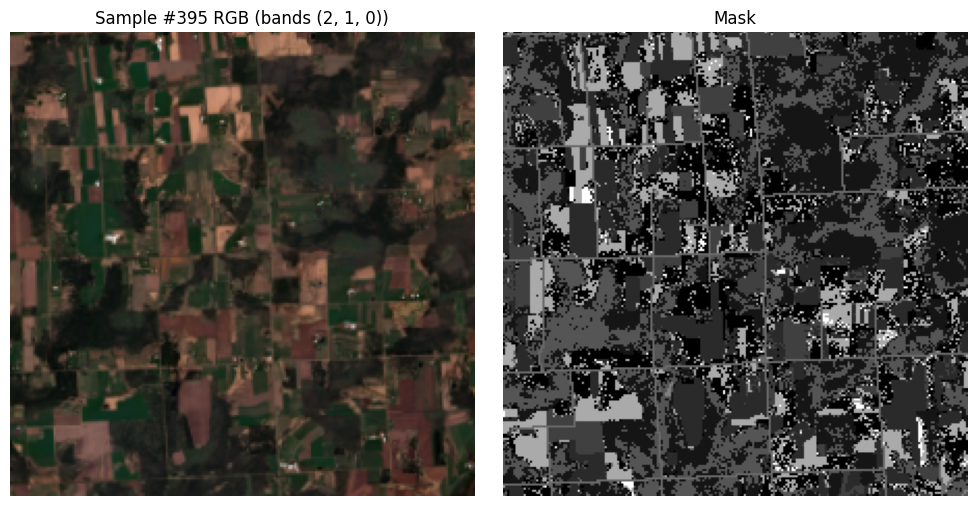

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',
    ignore_index=0,
)

ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_focal = focal_loss(preds, targets)

    return 1 * L_focal


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-7-8b7d0dabfa33>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [10:21<00:00,  7.97s/it]


[Epoch  0] Loss:  1.4690, Acc:   0.1294, IoU:   0.0628, Dice:  0.0637, mIoU:  0.0404


Epoch 1/50 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


[Epoch  0] Loss: 1.0143, Acc: 0.1917, IoU: 0.1007, Dice: 0.0877, mIoU: 0.0612


Epoch 2/50: 100%|██████████| 78/78 [05:24<00:00,  4.17s/it]


[Epoch  1] Loss:  0.8740, Acc:   0.2026, IoU:   0.1145, Dice:  0.0974, mIoU:  0.0691


Epoch 2/50 [Val]: 100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


[Epoch  1] Loss: 0.8108, Acc: 0.2324, IoU: 0.1307, Dice: 0.1040, mIoU: 0.0780


Epoch 3/50: 100%|██████████| 78/78 [05:38<00:00,  4.34s/it]


[Epoch  2] Loss:  0.7839, Acc:   0.2351, IoU:   0.1403, Dice:  0.1132, mIoU:  0.0858


Epoch 3/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


[Epoch  2] Loss: 0.7863, Acc: 0.2863, IoU: 0.1647, Dice: 0.1206, mIoU: 0.0938


Epoch 4/50: 100%|██████████| 78/78 [05:31<00:00,  4.25s/it]


[Epoch  3] Loss:  0.7438, Acc:   0.2603, IoU:   0.1617, Dice:  0.1275, mIoU:  0.1000


Epoch 4/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


[Epoch  3] Loss: 0.7327, Acc: 0.2870, IoU: 0.1773, Dice: 0.1295, mIoU: 0.1031


Epoch 5/50: 100%|██████████| 78/78 [05:07<00:00,  3.94s/it]


[Epoch  4] Loss:  0.7149, Acc:   0.2846, IoU:   0.1817, Dice:  0.1387, mIoU:  0.1103


Epoch 5/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


[Epoch  4] Loss: 0.7060, Acc: 0.3259, IoU: 0.2112, Dice: 0.1417, mIoU: 0.1134


Epoch 6/50: 100%|██████████| 78/78 [05:05<00:00,  3.92s/it]


[Epoch  5] Loss:  0.6987, Acc:   0.3236, IoU:   0.2097, Dice:  0.1480, mIoU:  0.1186


Epoch 6/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


[Epoch  5] Loss: 0.6921, Acc: 0.3226, IoU: 0.2096, Dice: 0.1469, mIoU: 0.1190


Epoch 7/50: 100%|██████████| 78/78 [05:02<00:00,  3.87s/it]


[Epoch  6] Loss:  0.6832, Acc:   0.3401, IoU:   0.2230, Dice:  0.1569, mIoU:  0.1265


Epoch 7/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.42s/it]


[Epoch  6] Loss: 0.6954, Acc: 0.3400, IoU: 0.2241, Dice: 0.1523, mIoU: 0.1245


Epoch 8/50: 100%|██████████| 78/78 [05:31<00:00,  4.25s/it]


[Epoch  7] Loss:  0.6704, Acc:   0.3554, IoU:   0.2363, Dice:  0.1653, mIoU:  0.1337


Epoch 8/50 [Val]: 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


[Epoch  7] Loss: 0.6934, Acc: 0.3629, IoU: 0.2298, Dice: 0.1612, mIoU: 0.1297


Epoch 9/50: 100%|██████████| 78/78 [05:33<00:00,  4.27s/it]


[Epoch  8] Loss:  0.6603, Acc:   0.3709, IoU:   0.2481, Dice:  0.1724, mIoU:  0.1403


Epoch 9/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


[Epoch  8] Loss: 0.6703, Acc: 0.3628, IoU: 0.2357, Dice: 0.1671, mIoU: 0.1357


Epoch 10/50: 100%|██████████| 78/78 [05:04<00:00,  3.91s/it]


[Epoch  9] Loss:  0.6452, Acc:   0.3857, IoU:   0.2597, Dice:  0.1798, mIoU:  0.1470


Epoch 10/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


[Epoch  9] Loss: 0.6692, Acc: 0.3974, IoU: 0.2587, Dice: 0.1769, mIoU: 0.1449


Epoch 11/50: 100%|██████████| 78/78 [05:07<00:00,  3.94s/it]


[Epoch 10] Loss:  0.6429, Acc:   0.3880, IoU:   0.2623, Dice:  0.1829, mIoU:  0.1499


Epoch 11/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.40s/it]


[Epoch 10] Loss: 0.6483, Acc: 0.3879, IoU: 0.2533, Dice: 0.1798, mIoU: 0.1480


Epoch 12/50: 100%|██████████| 78/78 [05:33<00:00,  4.27s/it]


[Epoch 11] Loss:  0.6312, Acc:   0.4038, IoU:   0.2744, Dice:  0.1899, mIoU:  0.1562


Epoch 12/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 11] Loss: 0.6758, Acc: 0.3711, IoU: 0.2452, Dice: 0.1672, mIoU: 0.1379


Epoch 13/50: 100%|██████████| 78/78 [05:30<00:00,  4.24s/it]


[Epoch 12] Loss:  0.6276, Acc:   0.4061, IoU:   0.2767, Dice:  0.1916, mIoU:  0.1579


Epoch 13/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.29s/it]


[Epoch 12] Loss: 0.6414, Acc: 0.4232, IoU: 0.2813, Dice: 0.1910, mIoU: 0.1580


Epoch 14/50: 100%|██████████| 78/78 [05:03<00:00,  3.89s/it]


[Epoch 13] Loss:  0.6174, Acc:   0.4183, IoU:   0.2857, Dice:  0.1969, mIoU:  0.1630


Epoch 14/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


[Epoch 13] Loss: 0.6797, Acc: 0.4115, IoU: 0.2716, Dice: 0.1902, mIoU: 0.1566


Epoch 15/50: 100%|██████████| 78/78 [05:02<00:00,  3.88s/it]


[Epoch 14] Loss:  0.6160, Acc:   0.4183, IoU:   0.2866, Dice:  0.1985, mIoU:  0.1647


Epoch 15/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


[Epoch 14] Loss: 0.6446, Acc: 0.4277, IoU: 0.2790, Dice: 0.1935, mIoU: 0.1594


Epoch 16/50: 100%|██████████| 78/78 [05:00<00:00,  3.85s/it]


[Epoch 15] Loss:  0.6080, Acc:   0.4274, IoU:   0.2936, Dice:  0.2022, mIoU:  0.1680


Epoch 16/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


[Epoch 15] Loss: 0.6458, Acc: 0.3965, IoU: 0.2665, Dice: 0.1821, mIoU: 0.1511


Epoch 17/50: 100%|██████████| 78/78 [05:17<00:00,  4.07s/it]


[Epoch 16] Loss:  0.6055, Acc:   0.4322, IoU:   0.2965, Dice:  0.2046, mIoU:  0.1705


Epoch 17/50 [Val]: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


[Epoch 16] Loss: 0.6953, Acc: 0.3674, IoU: 0.2515, Dice: 0.1726, mIoU: 0.1422


Epoch 18/50: 100%|██████████| 78/78 [05:34<00:00,  4.29s/it]


[Epoch 17] Loss:  0.5993, Acc:   0.4403, IoU:   0.3028, Dice:  0.2074, mIoU:  0.1734


Epoch 18/50 [Val]: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


[Epoch 17] Loss: 0.6376, Acc: 0.4183, IoU: 0.2811, Dice: 0.1944, mIoU: 0.1613


Epoch 19/50: 100%|██████████| 78/78 [05:19<00:00,  4.10s/it]


[Epoch 18] Loss:  0.5969, Acc:   0.4437, IoU:   0.3064, Dice:  0.2101, mIoU:  0.1760


Epoch 19/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


[Epoch 18] Loss: 0.6674, Acc: 0.4037, IoU: 0.2662, Dice: 0.1825, mIoU: 0.1500


Epoch 20/50: 100%|██████████| 78/78 [05:07<00:00,  3.95s/it]


[Epoch 19] Loss:  0.5891, Acc:   0.4492, IoU:   0.3106, Dice:  0.2118, mIoU:  0.1775


Epoch 20/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


[Epoch 19] Loss: 0.6676, Acc: 0.4272, IoU: 0.2744, Dice: 0.1980, mIoU: 0.1636


Epoch 21/50: 100%|██████████| 78/78 [05:06<00:00,  3.93s/it]


[Epoch 20] Loss:  0.5871, Acc:   0.4540, IoU:   0.3144, Dice:  0.2144, mIoU:  0.1803


Epoch 21/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


[Epoch 20] Loss: 0.6276, Acc: 0.3779, IoU: 0.2646, Dice: 0.1951, mIoU: 0.1644


Epoch 22/50: 100%|██████████| 78/78 [05:34<00:00,  4.29s/it]


[Epoch 21] Loss:  0.5825, Acc:   0.4582, IoU:   0.3176, Dice:  0.2164, mIoU:  0.1823


Epoch 22/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


[Epoch 21] Loss: 0.7215, Acc: 0.3203, IoU: 0.2139, Dice: 0.1789, mIoU: 0.1482


Epoch 23/50: 100%|██████████| 78/78 [05:38<00:00,  4.34s/it]


[Epoch 22] Loss:  0.5881, Acc:   0.4527, IoU:   0.3131, Dice:  0.2156, mIoU:  0.1812


Epoch 23/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 22] Loss: 0.6311, Acc: 0.4115, IoU: 0.2771, Dice: 0.1994, mIoU: 0.1662


Epoch 24/50: 100%|██████████| 78/78 [05:36<00:00,  4.32s/it]


[Epoch 23] Loss:  0.5791, Acc:   0.4635, IoU:   0.3220, Dice:  0.2190, mIoU:  0.1846


Epoch 24/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.40s/it]


[Epoch 23] Loss: 0.6253, Acc: 0.4323, IoU: 0.2941, Dice: 0.2050, mIoU: 0.1711


Epoch 25/50: 100%|██████████| 78/78 [05:04<00:00,  3.90s/it]


[Epoch 24] Loss:  0.5707, Acc:   0.4735, IoU:   0.3307, Dice:  0.2231, mIoU:  0.1890


Epoch 25/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


[Epoch 24] Loss: 0.6075, Acc: 0.4397, IoU: 0.3034, Dice: 0.2098, mIoU: 0.1772


Epoch 26/50: 100%|██████████| 78/78 [05:04<00:00,  3.90s/it]


[Epoch 25] Loss:  0.5690, Acc:   0.4759, IoU:   0.3317, Dice:  0.2234, mIoU:  0.1891


Epoch 26/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


[Epoch 25] Loss: 0.6748, Acc: 0.3889, IoU: 0.2641, Dice: 0.1968, mIoU: 0.1627


Epoch 27/50: 100%|██████████| 78/78 [05:35<00:00,  4.31s/it]


[Epoch 26] Loss:  0.5793, Acc:   0.4585, IoU:   0.3183, Dice:  0.2193, mIoU:  0.1843


Epoch 27/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 26] Loss: 0.6186, Acc: 0.4143, IoU: 0.2847, Dice: 0.2077, mIoU: 0.1741


Epoch 28/50: 100%|██████████| 78/78 [05:35<00:00,  4.30s/it]


[Epoch 27] Loss:  0.5665, Acc:   0.4771, IoU:   0.3333, Dice:  0.2253, mIoU:  0.1910


Epoch 28/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.37s/it]


[Epoch 27] Loss: 0.6192, Acc: 0.4257, IoU: 0.2964, Dice: 0.2081, mIoU: 0.1748


Epoch 29/50: 100%|██████████| 78/78 [05:04<00:00,  3.90s/it]


[Epoch 28] Loss:  0.5712, Acc:   0.4731, IoU:   0.3295, Dice:  0.2238, mIoU:  0.1892


Epoch 29/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.42s/it]


[Epoch 28] Loss: 0.6062, Acc: 0.4429, IoU: 0.3078, Dice: 0.2111, mIoU: 0.1783


Epoch 30/50: 100%|██████████| 78/78 [05:06<00:00,  3.93s/it]


[Epoch 29] Loss:  0.5619, Acc:   0.4831, IoU:   0.3377, Dice:  0.2276, mIoU:  0.1933


Epoch 30/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.48s/it]


[Epoch 29] Loss: 0.6790, Acc: 0.4066, IoU: 0.2670, Dice: 0.1925, mIoU: 0.1590


Epoch 31/50: 100%|██████████| 78/78 [05:33<00:00,  4.27s/it]


[Epoch 30] Loss:  0.5675, Acc:   0.4771, IoU:   0.3333, Dice:  0.2260, mIoU:  0.1918


Epoch 31/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.08s/it]


[Epoch 30] Loss: 0.6238, Acc: 0.4170, IoU: 0.2920, Dice: 0.2054, mIoU: 0.1724


Epoch 32/50: 100%|██████████| 78/78 [05:37<00:00,  4.33s/it]


[Epoch 31] Loss:  0.5530, Acc:   0.4919, IoU:   0.3447, Dice:  0.2306, mIoU:  0.1970


Epoch 32/50 [Val]: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


[Epoch 31] Loss: 0.5890, Acc: 0.4497, IoU: 0.3147, Dice: 0.2160, mIoU: 0.1830


Epoch 33/50: 100%|██████████| 78/78 [05:27<00:00,  4.20s/it]


[Epoch 32] Loss:  0.5564, Acc:   0.4867, IoU:   0.3417, Dice:  0.2298, mIoU:  0.1958


Epoch 33/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.45s/it]


[Epoch 32] Loss: 0.5996, Acc: 0.4311, IoU: 0.3077, Dice: 0.2122, mIoU: 0.1808


Epoch 34/50: 100%|██████████| 78/78 [05:09<00:00,  3.96s/it]


[Epoch 33] Loss:  0.5490, Acc:   0.4970, IoU:   0.3492, Dice:  0.2330, mIoU:  0.1991


Epoch 34/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.46s/it]


[Epoch 33] Loss: 0.5851, Acc: 0.4459, IoU: 0.3087, Dice: 0.2167, mIoU: 0.1843


Epoch 35/50: 100%|██████████| 78/78 [05:34<00:00,  4.29s/it]


[Epoch 34] Loss:  0.5429, Acc:   0.5036, IoU:   0.3555, Dice:  0.2352, mIoU:  0.2017


Epoch 35/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 34] Loss: 0.7690, Acc: 0.3730, IoU: 0.2274, Dice: 0.1691, mIoU: 0.1365


Epoch 36/50: 100%|██████████| 78/78 [05:33<00:00,  4.27s/it]


[Epoch 35] Loss:  0.5429, Acc:   0.5011, IoU:   0.3532, Dice:  0.2350, mIoU:  0.2015


Epoch 36/50 [Val]: 100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


[Epoch 35] Loss: 0.5953, Acc: 0.4520, IoU: 0.3146, Dice: 0.2168, mIoU: 0.1847


Epoch 37/50: 100%|██████████| 78/78 [05:37<00:00,  4.33s/it]


[Epoch 36] Loss:  0.5440, Acc:   0.5028, IoU:   0.3555, Dice:  0.2354, mIoU:  0.2019


Epoch 37/50 [Val]: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


[Epoch 36] Loss: 0.6529, Acc: 0.4331, IoU: 0.2951, Dice: 0.2098, mIoU: 0.1766


Epoch 38/50: 100%|██████████| 78/78 [05:22<00:00,  4.13s/it]


[Epoch 37] Loss:  0.5385, Acc:   0.5084, IoU:   0.3581, Dice:  0.2378, mIoU:  0.2042


Epoch 38/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.40s/it]


[Epoch 37] Loss: 0.5923, Acc: 0.4728, IoU: 0.3195, Dice: 0.2195, mIoU: 0.1865


Epoch 39/50: 100%|██████████| 78/78 [05:04<00:00,  3.91s/it]


[Epoch 38] Loss:  0.5365, Acc:   0.5112, IoU:   0.3618, Dice:  0.2391, mIoU:  0.2057


Epoch 39/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


[Epoch 38] Loss: 0.5726, Acc: 0.4787, IoU: 0.3310, Dice: 0.2271, mIoU: 0.1945


Epoch 40/50: 100%|██████████| 78/78 [05:29<00:00,  4.23s/it]


[Epoch 39] Loss:  0.5302, Acc:   0.5165, IoU:   0.3664, Dice:  0.2413, mIoU:  0.2082


Epoch 40/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.00s/it]


[Epoch 39] Loss: 0.5787, Acc: 0.4633, IoU: 0.3228, Dice: 0.2255, mIoU: 0.1916


Epoch 41/50: 100%|██████████| 78/78 [05:29<00:00,  4.22s/it]


[Epoch 40] Loss:  0.5278, Acc:   0.5186, IoU:   0.3680, Dice:  0.2423, mIoU:  0.2092


Epoch 41/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 40] Loss: 0.5967, Acc: 0.4592, IoU: 0.3131, Dice: 0.2181, mIoU: 0.1853


Epoch 42/50: 100%|██████████| 78/78 [05:35<00:00,  4.31s/it]


[Epoch 41] Loss:  0.5264, Acc:   0.5230, IoU:   0.3717, Dice:  0.2435, mIoU:  0.2104


Epoch 42/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.40s/it]


[Epoch 41] Loss: 0.5921, Acc: 0.4457, IoU: 0.3051, Dice: 0.2223, mIoU: 0.1875


Epoch 43/50: 100%|██████████| 78/78 [05:13<00:00,  4.02s/it]


[Epoch 42] Loss:  0.5296, Acc:   0.5179, IoU:   0.3681, Dice:  0.2422, mIoU:  0.2092


Epoch 43/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


[Epoch 42] Loss: 0.5952, Acc: 0.4420, IoU: 0.3085, Dice: 0.2210, mIoU: 0.1867


Epoch 44/50: 100%|██████████| 78/78 [05:33<00:00,  4.28s/it]


[Epoch 43] Loss:  0.5221, Acc:   0.5275, IoU:   0.3754, Dice:  0.2455, mIoU:  0.2126


Epoch 44/50 [Val]: 100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


[Epoch 43] Loss: 0.5794, Acc: 0.4580, IoU: 0.3191, Dice: 0.2275, mIoU: 0.1946


Epoch 45/50: 100%|██████████| 78/78 [05:30<00:00,  4.24s/it]


[Epoch 44] Loss:  0.5271, Acc:   0.5256, IoU:   0.3748, Dice:  0.2454, mIoU:  0.2126


Epoch 45/50 [Val]: 100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


[Epoch 44] Loss: 0.5971, Acc: 0.4377, IoU: 0.3060, Dice: 0.2182, mIoU: 0.1852


Epoch 46/50: 100%|██████████| 78/78 [05:32<00:00,  4.27s/it]


[Epoch 45] Loss:  0.5153, Acc:   0.5342, IoU:   0.3819, Dice:  0.2492, mIoU:  0.2164


Epoch 46/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


[Epoch 45] Loss: 0.5669, Acc: 0.4819, IoU: 0.3351, Dice: 0.2299, mIoU: 0.1977


Epoch 47/50: 100%|██████████| 78/78 [05:04<00:00,  3.90s/it]


[Epoch 46] Loss:  0.5129, Acc:   0.5376, IoU:   0.3853, Dice:  0.2499, mIoU:  0.2174


Epoch 47/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.36s/it]


[Epoch 46] Loss: 0.6069, Acc: 0.4387, IoU: 0.3037, Dice: 0.2139, mIoU: 0.1824


Epoch 48/50: 100%|██████████| 78/78 [05:00<00:00,  3.85s/it]


[Epoch 47] Loss:  0.5258, Acc:   0.5211, IoU:   0.3719, Dice:  0.2439, mIoU:  0.2109


Epoch 48/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


[Epoch 47] Loss: 0.5634, Acc: 0.4691, IoU: 0.3313, Dice: 0.2296, mIoU: 0.1974


Epoch 49/50: 100%|██████████| 78/78 [06:18<00:00,  4.86s/it]


[Epoch 48] Loss:  0.5134, Acc:   0.5390, IoU:   0.3854, Dice:  0.2504, mIoU:  0.2178


Epoch 49/50 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


[Epoch 48] Loss: 0.5706, Acc: 0.4696, IoU: 0.3304, Dice: 0.2285, mIoU: 0.1963


Epoch 50/50: 100%|██████████| 78/78 [05:16<00:00,  4.06s/it]


[Epoch 49] Loss:  0.5091, Acc:   0.5403, IoU:   0.3878, Dice:  0.2515, mIoU:  0.2191


Epoch 50/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.45s/it]

[Epoch 49] Loss: 0.5697, Acc: 0.4826, IoU: 0.3316, Dice: 0.2289, mIoU: 0.1960


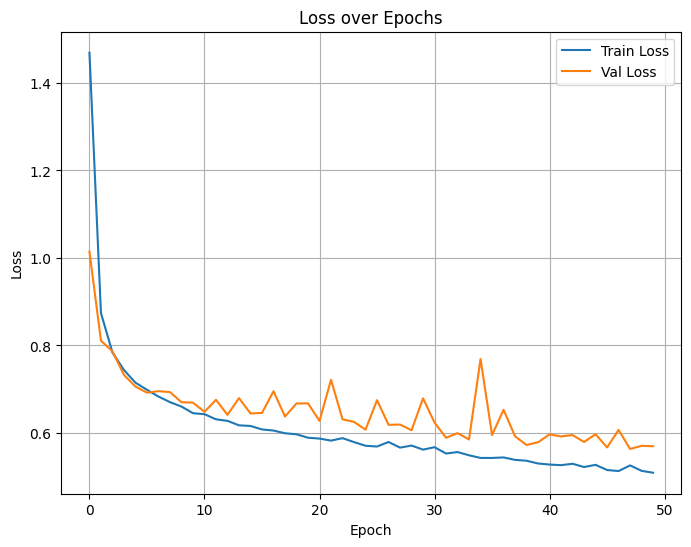

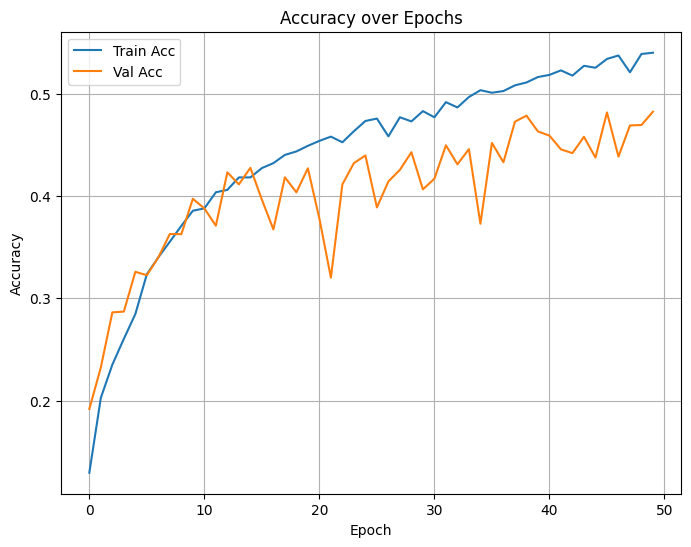

In [9]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_loss_20250515-205559_normalized_focal.png


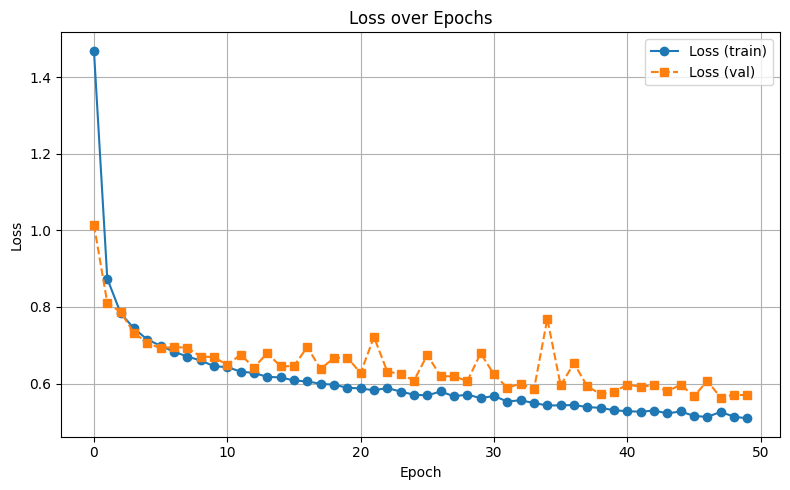

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250515-205559_normalized_focal.png


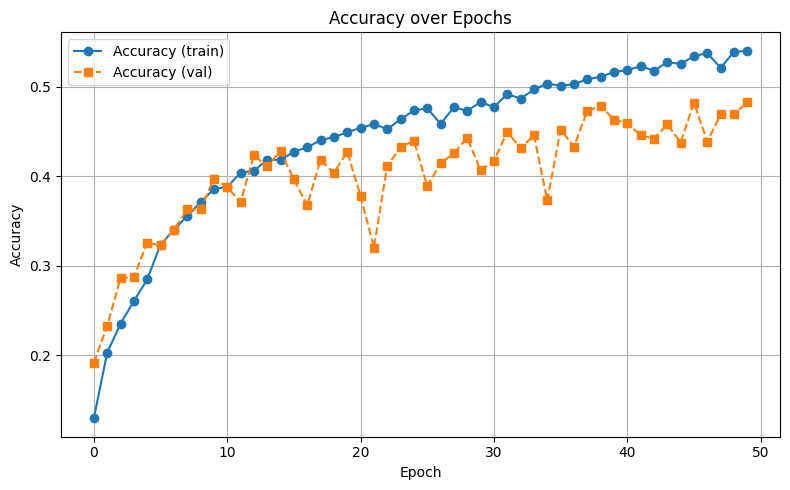

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_iou_20250515-205559_normalized_focal.png


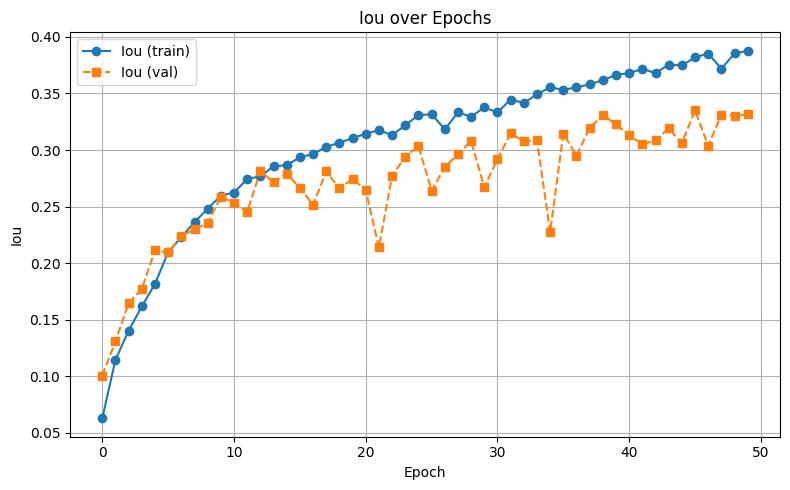

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_dice_20250515-205559_normalized_focal.png


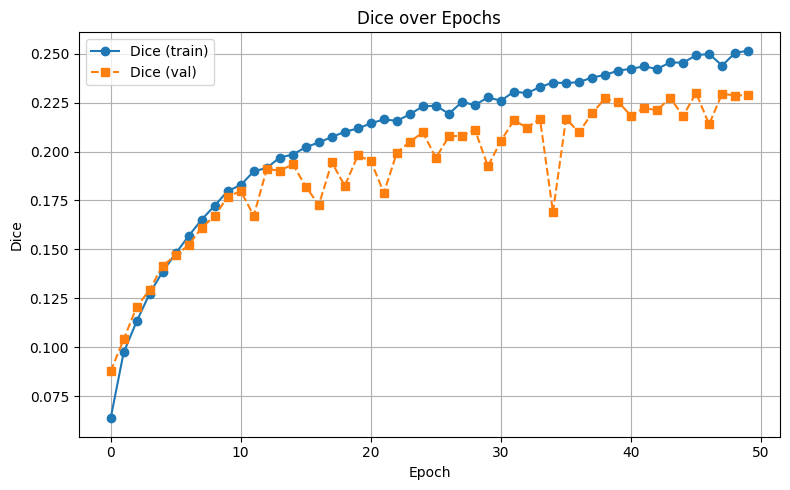

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_miou_20250515-205559_normalized_focal.png


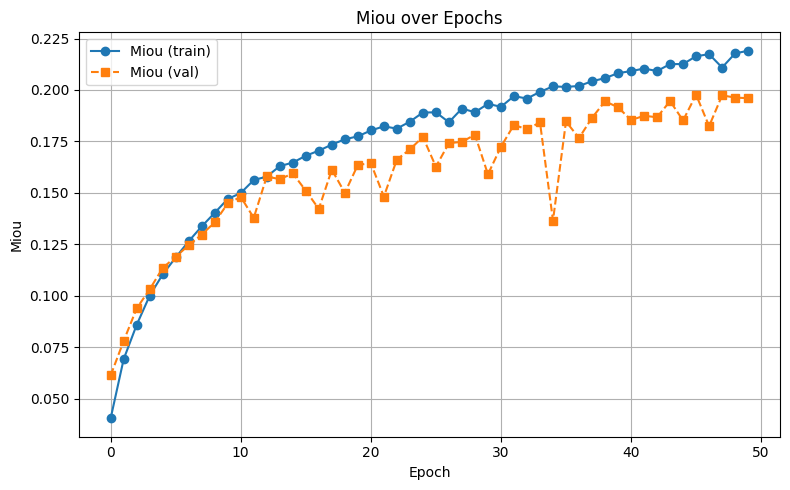

In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_focal.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [11]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_focal.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_focal.pth


In [12]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_focal_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_focal_metrics.csv
